In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6,7"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
import torch
from sema_guidance import StableDiffusionFreeGuidancePipeline
# from sema_guidance import StableDiffusionFreeGuidancePipeline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from tqdm.auto import tqdm
from torch.nn import init
from utils.guidance_functions import *
import argparse
from diffusers import LMSDiscreteScheduler, DDPMScheduler, DDIMScheduler, DPMSolverMultistepScheduler
from utils import *
from PIL import Image
torch.cuda.manual_seed_all(1234) 
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray_r'


/root/anaconda3/envs/free_guide/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

print("Start Inference!")
model_id = "runwayml/stable-diffusion-v1-5"
device = "cuda"
NUM_DDIM_STEPS = 50
pipe = StableDiffusionFreeGuidancePipeline.from_pretrained(model_id, torch_dtype=torch.float16, variant="fp16")
pipe.unet = UNetDistributedDataParallel(pipe.unet, device_ids=[0]).cuda()
# pipe.vae = UNetDistributedDataParallel(pipe.vae, device_ids=[0,1,2]).cuda()
# pipe.text_encoder = UNetDistributedDataParallel(pipe.text_encoder, device_ids=[0,1,2]).cuda()
# pipe.unet = pipe.unet.to(device)
# pipe.text_encoder = UNetDistributedDataParallel(pipe.text_encoder, device_ids=[0,1,2,3,4], output_device=3).cuda()
# pipe.unet.config, pipe.unet.dtype, pipe.unet.attn_processors, pipe.unet.set_attn_processor = pipe.unet.module.config, pipe.unet.module.dtype, pipe.unet.module.attn_processors, pipe.unet.module.set_attn_processor
# pipe.unet.config, pipe.unet.dtype = pipe.unet.module.config, pipe.unet.module.dtype
pipe.unet = pipe.unet.module
pipe = pipe.to(device)

# pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config) # DDPMScheduler -> DDIMScheduler
pipe.scheduler.set_timesteps(NUM_DDIM_STEPS)

pipe.enable_attention_slicing()
torch.backends.cudnn.benchmark = True

Start Inference!


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]


Model loaded successfully!


cross_attention dimension
down_blocks：
4096 4096
1024 1024
256 256
mid：
64
up_block：
256 256 256
1024 1024 1024
4096 4096 4096
res activation
down_blocks：
layer1 (1,320,64,64)
layer2 (1,640,32,32)
layer3 (1,1280,16,16)
layer4 (1,1280,8,8)
up_block：
layer1 (1,1280,8,8)
layer2 (1,1280,16,16)
layer3 (1,640,32,32)
layer4 (1,320,64,64)

13519


100%|██████████| 50/50 [03:07<00:00,  3.76s/it]


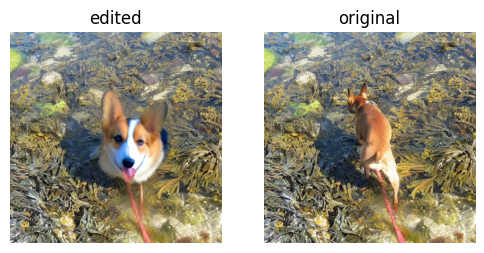

In [5]:
seed = int(torch.rand((1,)) * 100000)
generator=torch.manual_seed(seed)
print(seed)

prompts = ["a dog in the liver", 
           "a corgi in the liver"]

object_to_edit = 'corgi'

guidance = partial(match_semantic_feature, position_weight=6.0, sem_weight=0.0)
# move = partial(roll_shape, direction='up', factor=0.0)
# guidance = partial(move_object_by_shape, shape_weight=0.5, appearance_weight=1.5, position_weight=6, tau=move)

img_path = './img/shepherd.png'
latents = get_ddim_latents(pipe, img_path, prompts[0], device)
init_latent = latents[-1]

image_list = pipe(prompts[1], prompts[0], obj_to_edit = object_to_edit, height=512, width=512, 
                  num_inference_steps=50, generator=generator, latents=init_latent, all_latents=latents,
                  max_guidance_iter_per_step=15, guidance_func=guidance, g_weight=500)
show_images([i for i in [image_list[0].images[0], image_list[1].images[0]]], titles=['edited', 'original'], save_orig=True)

In [4]:
seed = int(torch.rand((1,)) * 100000)
generator=torch.manual_seed(seed)
print(seed)

prompt = 'a photo of a donut and a shot of espresso on a table'
object_to_edit = 'donut'
objects = ['donut', 'espresso']
move = partial(roll_shape, direction='up', factor=0.4)
guidance = partial(move_object_by_shape, shape_weight=0.5, appearance_weight=1.5, position_weight=6, tau=move)

img_path = './img/donut.png' 
latents = get_ddim_latents(pipe, img_path, prompt, device)
init_latents = latents[-1]
# init_latents = get_latents_from_image(pipe, img_path, device)

image_list = pipe(prompt, obj_to_edit = object_to_edit, height=512, width=512, 
                  num_inference_steps=50, generator=generator, latents=init_latents, all_latents=latents,
                  max_guidance_iter_per_step=15, guidance_func=guidance, g_weight=3000)
show_images([i for i in [image_list[0].images[0], image_list[1].images[0]]], titles=['edited', 'original'], save_orig=True)

6229


 20%|██        | 10/50 [01:59<07:59, 11.99s/it]


KeyboardInterrupt: 

32806


100%|██████████| 50/50 [04:16<00:00,  5.12s/it]


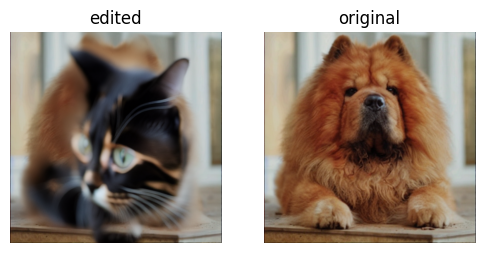

In [ ]:
seed = int(torch.rand((1,)) * 100000)
generator=torch.manual_seed(seed)
print(seed)

prompts = ["a photo of a dog", 
           "a photo of a cat"]

object_to_edit = 'cat'
move = partial(roll_shape, direction='up', factor=0.4)
guidance = partial(move_object_by_shape, shape_weight=0.5, appearance_weight=1.5, position_weight=6, tau=move)

img_path = './img/dog.png'
latents = get_ddim_latents(pipe, img_path, prompts[0], device)
init_latent = latents[-1]

image_list = pipe(prompts[1], prompts[0], obj_to_edit = object_to_edit, height=512, width=512, 
                  num_inference_steps=50, generator=generator, latents=init_latent, all_latents=latents,
                  max_guidance_iter_per_step=15, guidance_func=guidance, g_weight=0)
show_images([i for i in [image_list[0].images[0], image_list[1].images[0]]], titles=['edited', 'original'], save_orig=True)

## Swapping word

In [ ]:
def make_controller(prompts: List[str], is_replace_controller: bool, cross_replace_steps: Dict[str, float], self_replace_steps: float, blend_words=None, equilizer_params=None) -> AttentionControlEdit:
    if blend_words is None:
        lb = None
    else:
        lb = LocalBlend(prompts, blend_word)
    if is_replace_controller:
        controller = AttentionReplace(prompts, NUM_DDIM_STEPS, cross_replace_steps=cross_replace_steps, self_replace_steps=self_replace_steps, local_blend=lb)
    else:
        controller = AttentionRefine(prompts, NUM_DDIM_STEPS, cross_replace_steps=cross_replace_steps, self_replace_steps=self_replace_steps, local_blend=lb)
    if equilizer_params is not None:
        eq = get_equalizer(prompts[1], equilizer_params["words"], equilizer_params["values"])
        controller = AttentionReweight(prompts, NUM_DDIM_STEPS, cross_replace_steps=cross_replace_steps,
                                       self_replace_steps=self_replace_steps, equalizer=eq, local_blend=lb, controller=controller)
    return controller

def run_and_display(prompts, controller, latent=None, run_baseline=False, generator=None, uncond_embeddings=None, verbose=True):
    if run_baseline:
        print("w.o. prompt-to-prompt")
        images, latent = run_and_display(prompts, EmptyControl(), latent=latent, run_baseline=False, generator=generator)
        print("with prompt-to-prompt")
    images, x_t = text2image_ldm_stable(ldm_stable, prompts, controller, latent=latent, num_inference_steps=NUM_DDIM_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator, uncond_embeddings=uncond_embeddings)
    if verbose:
        ptp_utils.view_images(images)
    return images, x_t

NameError: name 'Dict' is not defined

In [ ]:
prompts = ['a photo of a dog',
           'a photo of a cat'
        ]

cross_replace_steps = {'default_': .8,}
self_replace_steps = .5
blend_word = ((('dog',), ('cat', )))
eq_params = {"words": ("cat",), "values": (2,)}

controller = make_controller(prompts, True, cross_replace_steps, self_replace_steps, blend_word, eq_params)
images, _ = run_and_display(prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=uncond_embeddings)

print("Image is highly affected by the self_replace_steps, usually 0.4 is a good default value, but you may want to try the range 0.3,0.4,0.5,0.7 ")